In [3]:
import arrow
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
# TODO:[-] 25-06-03 keras.src 路径是 TensorFlow 2.11 及更高版本中集成在 TensorFlow 内部的 Keras 3 中使用的。
# from keras.src.layers import LSTM, Dropout, Bidirectional, Dense, Masking
from keras.layers import LSTM, Dropout, Bidirectional, Dense, Masking
from pandas import DatetimeIndex
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from tensorflow.keras.losses import MeanSquaredError
# 可视化结果（如果需要）
import matplotlib.pyplot as plt
import os
import pathlib
import xml.etree.ElementTree as ET
import xarray as xr
import codecs
import datetime
import math

# 先从海浪数据中提取出经纬度，时间，风，海浪高度
# 解析单个文件，并存于字典内
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
forecast_path: str = r'Z:\SOURCE_MERGE_DATA\df_ws_forecast.csv'
realdata_path: str = r'Z:\SOURCE_MERGE_DATA\2024_local_df_utc_183_split.csv'
'''按照三小时一个提取的实况数据路径'''
model_path: str = r'Z:\02TRAINNING_MODEL\fit_model_v3.2_250622_0_48.h5'
# scaler_forecast: str = r'Z:\01TRAINNING_DATA\scaler\scaler_forecast_250609.sav'
# scaler_realdata: str = r'Z:\01TRAINNING_DATA\scaler\scaler_realdata_250609.sav'

#### 新增修改，只提取[0,24]的数据

In [5]:
 # step1: 加载标准化后的 预报 | 实况 数据集
# shape: (61,732)
df_forecast = pd.read_csv(forecast_path, encoding='utf-8', index_col=0)
# shape:(61,731)
df_realdata = pd.read_csv(realdata_path, encoding='utf-8', index_col=0)
# 实况拼接有问题需要手动去掉最后一列
# 使用按3小时进行分割的数据不需要去掉最后一列，这样 realdata 与 forecast 的 columns 一致
# df_realdata = df_realdata.drop(df_realdata.columns[-1], axis=1)
df_forecast = df_forecast.iloc[:61, :]

#### 注意此处需要对实况数据与预报数据对其  
实况数据已经进行了拆分（提取了时间间隔为3hour的实况数据）

In [6]:
df_forecast.head()

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,2.923878,9.315406,5.012707,3.827535,7.922782,7.508249,10.098755,6.931345,7.173455,5.142837,...,8.743365,8.087823,6.933784,5.954374,5.939341,9.051125,6.255262,10.815748,2.710204,11.655143
1,6.530825,10.155370,3.986798,3.946773,5.445124,9.135552,9.633334,9.233833,3.393676,6.577634,...,8.122977,9.979736,8.622316,6.085054,8.969516,9.038375,7.546649,8.284430,5.122671,10.364008
2,8.889989,9.057070,3.408297,4.889753,3.289932,9.488909,10.207234,10.298507,1.344447,7.846056,...,7.816586,8.706822,9.970959,4.476284,11.169362,8.924077,8.936747,9.210247,9.479596,7.171209
3,9.039523,6.656440,4.539793,8.769405,4.212557,10.969419,8.871683,10.377746,4.269206,8.143950,...,7.456558,8.165563,7.588914,5.417556,11.360951,8.352539,10.649641,7.110746,10.821920,8.756545
4,8.654149,4.121097,4.043969,7.281161,7.424704,11.250175,8.345333,6.764350,6.505871,9.279316,...,8.452628,9.429845,5.237637,7.014868,10.349231,7.226018,10.895060,2.116098,11.402069,8.556267


In [7]:
df_realdata.head()

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,4.0,12.8,4.5,2.4,8.8,9.1,11.8,9.1,4.7,5.6,...,8.6,8.8,9.5,5.7,7.2,8.5,8.2,9.7,1.7,12.0
1,NaN,9.3,NaN,4.6,NaN,9.6,NaN,7.5,NaN,6.5,...,7.0,9.2,7.1,5.3,9.5,8.9,7.6,5.6,4.8,8.8
2,10.6,10.8,1.7,2.7,1.2,9.4,6.8,7.2,2.4,5.9,...,6.6,7.6,7.7,4.5,11.2,10.8,3.9,7.5,10.0,NaN
3,11.9,8.6,2.8,6.1,5.8,11.7,8.2,8.4,3.9,6.6,...,6.7,7.6,7.0,6.6,11.1,10.3,3.7,4.8,12.5,NaN
4,12.8,4.5,2.4,8.8,9.1,11.8,9.1,4.7,5.6,9.5,...,8.8,9.5,5.7,7.2,8.5,8.2,9.7,1.7,12.0,NaN


In [8]:
step=3
start_hour = 0
end_hour = 48

In [9]:
# 计算开始索引
# 注意：start_hour 和 end_hour 是以小时为单位的
start_index=math.ceil(start_hour/step)
# 计算结束索引
end_index=math.ceil(end_hour/step)

In [10]:
start_index,end_index

(0, 16)

In [11]:
df_forecast_split=df_forecast.iloc[start_index:end_index,:]
df_forecast_split.shape

(16, 732)

In [12]:
df_realdata_split= df_realdata.iloc[start_index:end_index,:]
df_realdata_split.shape

(16, 732)

In [13]:
# 手动将上面切分后的 df_forecast_24 与 df_realdata_24 赋值给 df_forecast 和 df_realdata
df_forecast = df_forecast_split
df_realdata = df_realdata_split

#### step2: 将[0,24]的数据作为训练及预测数据

In [14]:
# step3: 数据标准化(提出nan值)
rows: int = df_forecast.shape[0]
cols: int = df_realdata.shape[1]
# TODO:[-] 25-05-28 注意原始数据中: forecast (61,732), real (61,732)
X = df_forecast.values.T.reshape(cols, rows, 1)
# TODO:[*] 25-05-11 注意 y 中有存在 nan
# ValueError: cannot reshape array of size 52776 into shape (732,72,1)
y = df_realdata.values.T.reshape(cols, rows, 1)
# step3-2:对数据进行归一化
# 拍扁数据为二维数组（n*timesteps, feature）进行归一化
X_flat = X.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
# 分别为 X 和 y 定义归一化器（当然如果两者量纲一致，可用同一个 scaler）
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X_flat)
y_scaled = scaler_y.fit_transform(y_flat)
# TODO:[-] 25-06-09 保存归一化器
# joblib.dump(scaler_X, scaler_forecast)
# joblib.dump(scaler_y, scaler_realdata)
# 将归一化后的二维数据恢复为原来的3D形状
X = X_scaled.reshape(X.shape)
y = y_scaled.reshape(y.shape)

`X`为特征或输入数据，这是模型用来进行预测的依据。  
`y`: 通常是一个数组或Series，代表了你的标签 (Labels) 或 目标变量 (Target)。这是你希望模型学会预测的“正确答案”。  
在这里`X`就是原始风场的预报结果;`y`就是实况数据

这是一个非常重要的参数，用于控制数据的随机性。在分割数据之前，函数会先将数据进行随机打乱，以确保训练集和测试集中的数据分布是相似的。  
random_state 相当于为这个随机过程设定一个**“种子”。只要这个数字（这里是 42）不变，那么每次运行这段代码，你得到的分割结果都将是完全一样的**。  
这对于保证实验的可复现性至关重要。如果你想和同事分享你的代码，或者自己重复实验来比较不同模型的效果，设置 random_state 可以确保你们都是在完全相同的数据分割上进行操作。数字 42 本身没有特殊含义，任何整数都可以，它只是一个社区中常用的约定。

| 变量名  | 包含内容           | 作用                          | 占比  |
|--------|------------------|-----------------------------|------|
| X_train | 特征 (Features)  | 用于训练模型                | 80%  |
| y_train | 标签 (Labels)    | 作为训练时的标准答案        | 80%  |
| X_test  | 特征 (Features)  | 用于测试模型，模型在训练时未见过 | 20%  |
| y_test  | 标签 (Labels)    | 作为测试时的评分依据，模型在训练时未见过 | 20%  |


## 一个形象的比喻

你可以把这个过程想象成一个学生准备考试：

- **X_train 和 y_train** 是 **教科书** 和 **所有课后练习题（及答案）**。学生（模型）通过学习这些材料来掌握知识。
- **X_test** 是 **期末考试的试卷（只有题目）**。这些题目是学生以前从未见过的。
- **y_test** 是 **老师手里的标准答案**。老师用它来批改学生的考卷，并给出最终分数。

这个分割过程确保了我们能公正地评估模型是否真正“学到”了知识，而不是仅仅“背下”了练习题。


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((585, 16, 1), (585, 16, 1), (147, 16, 1), (147, 16, 1))

##### step3: 数据标准化(剔除奇异值)

In [17]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
# step4: 构建模型
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan=0.0)
y_test = np.nan_to_num(y_test, nan=0.0)

#### step4: 构建模型

In [75]:
# model_path=r'Z:\02TRAINNING_MODEL\fit_model_v3.1_24_250618.h5'

In [18]:
# TODO:[-] 25-06-12 屏蔽是会去掉该时刻的所有数据吗？
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(16, 1)))
# step2: 添加双向LSTM层
# 双向 LSTM 同时从前向和后向处理时序数据，从而捕获更多上下文信息，提升特征提取能力。
# units=128：LSTM 层中每个方向上有 128 个神经元。
# return_sequences=True：输出每个时间步的结果，而非仅仅输出最后时刻的状态，这样可以将整个序列的信息传递到下一层。
# activation='relu'：将激活函数设置为 ReLU（而非 LSTM 默认的 tanh），可能有助于缓解梯度消失问题，不过这取决于具体任务。
# 注意：虽然此处指定了 input_shape=(25, 1)，但实际上在 Sequential 模型中第一层已经指定了输入形状，所以这里的 input_shape 参数可能是不必要或引起混淆（建议保持与 Masking 层一致，即 (61, 1)）。
# v1 激活函数:relu
# v2 改为: tanh
model.add(Bidirectional(LSTM(units=256, return_sequences=True,
                             activation='tanh',
                             input_shape=(16, 1))))
# step3: 添加 Dropout 层，在训练时随机将 20% 的神经元输出设为 0。
# Dropout 是一种正则化方法，有助于防止模型过拟合；通过随机丢弃部分神经元，模型不能过分依赖局部特征，从而提高泛化能力。
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh')))  # 可以堆叠多个LSTM层
# step5: 再次添加一个 Dropout 层，使得第二层 LSTM 的输出在训练时有 20% 被随机置零，从而进一步防止过拟合。
model.add(Dropout(0.2))
# step4: 第二层双向LSTM层
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh')))  # 可以堆叠多个LSTM层
# step5: 再次添加一个 Dropout 层，使得第二层 LSTM 的输出在训练时有 20% 被随机置零，从而进一步防止过拟合。
model.add(Dropout(0.2))
# step6: 添加全连接层（Dense 层），输出节点数为 25。25-06-12 此处修改为 61 ，需要预测长度为61的时间向量
# Dense 层将前面的时序特征映射到目标空间。在时序网络中，当上层返回整个序列（形状为 [batch_size, time_steps, features]）时，Dense 层会被逐时步地应用，输出每个时间步对应一个长度为 25 的向量。这通常用于预测任务，比如多步预测或者每个时刻有多个目标值的任务。
# TODO:[*] 25-06-17 此处将最后一个全链接层节点数由 25 -> 1
model.add(Dense(1))
# 将均方误差修改为均方根误差后
# step7: 编译模型
# optimizer='adam' 使用 Adam 优化器进行梯度下降更新。Adam 优化器能够自适应调整各参数的学习率，通常能较快收敛，并且对超参数设定不太敏感，不同于传统的 SGD。
# TODO:[*] 25-06-12 什么是超参数？
# loss='mse' 将损失函数设为均方误差（Mean Squared Error），这是回归问题常用的误差度量指标，模型训练的目标就是尽可能使预测值与真实值之间的均方误差最小化。
# 整体作用 model.compile() 会对模型进行配置，指定训练时用哪个优化器、用哪个损失函数，如果需要，还可以添加额外的评估指标。编译过程会为模型建立必要的计算图，并对参数进行初始化。
model.compile(optimizer='adam', loss='mse')
# ---------------------------------------------
# step8: 训练模型
# X_train, y_train 分别为训练数据和对应目标值。模型将以这些数据为依据不断调整参数，使预测值与真实目标值之间的 MSE 最小化。
# epochs=10 指定训练过程需要遍历整个训练集 10 次。每个 epoch 内部数据会根据 batch 大小分批更新参数。
# batch_size=16 每个训练步骤（step）使用 16 个样本进行梯度计算和模型更新。较小的 batch size 有助于捕捉更多细微变化，但训练时间可能更长；较大的 batch size 则计算稳定但可能导致泛化性下降。
# validation_data=(X_test, y_test) 在每个 epoch 结束后，模型也会评估一次在验证集上的损失。这有助于监控过拟合情况以及训练过程的稳定性。
# 将 validation_data 从 (X_test, y_test) 修改为 (X_test, y_test, val_weights)
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))
model.save(model_path)

Epoch 1/10
37/37 [==============================] - 32s 371ms/step - loss: 0.0255 - val_loss: 0.0199
Epoch 2/10
37/37 [==============================] - 7s 201ms/step - loss: 0.0178 - val_loss: 0.0186
Epoch 3/10
37/37 [==============================] - 6s 170ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 4/10
37/37 [==============================] - 7s 192ms/step - loss: 0.0160 - val_loss: 0.0181
Epoch 5/10
37/37 [==============================] - 8s 218ms/step - loss: 0.0154 - val_loss: 0.0180
Epoch 6/10
37/37 [==============================] - 7s 180ms/step - loss: 0.0154 - val_loss: 0.0172
Epoch 7/10
37/37 [==============================] - 6s 159ms/step - loss: 0.0150 - val_loss: 0.0168
Epoch 8/10
37/37 [==============================] - 6s 177ms/step - loss: 0.0150 - val_loss: 0.0165
Epoch 9/10
37/37 [==============================] - 7s 197ms/step - loss: 0.0150 - val_loss: 0.0178
Epoch 10/10
37/37 [==============================] - 7s 182ms/step - loss: 0.0148 - val_loss: 0.016

#### step5: 模型评估

In [19]:
X_test.shape, y_test.shape

((147, 16, 1), (147, 16, 1))

* 注意此处存在一个隐藏的bug，此处不能使用`X_test`是作为训练时的对比的真实数据，应该采用`y_train`

In [ ]:
# y_pred=model.predict(X_test)

In [20]:
# X_test.shape

 TODO:[*] 25-06-19 测试数据应使用2025年的实况+风场预报  
 暂时将2024年的数据再进行切分

In [21]:
y_pred=model.predict(X_test)

5/5 [==============================] - 5s 32ms/step


In [19]:
y_pred.shape

(147, 8, 1)

 1. 使用 scaler_y 来进行反归一化，因为 y_pred 是对 y_scaled 的预测
 2. 修改变量名以反映其真实含义

In [22]:
y_pred_denormalize=scaler_y.inverse_transform(y_pred.reshape(-1, 1))

3. 将反归一化后的数据恢复为与 y_test 相同的3D形状  


In [23]:
y_pred_denormalize = y_pred_denormalize.reshape(y_pred.shape)

In [30]:
y_pred_denormalize.shape

(147, 8, 1)

* 注意numpy.ndarray可以通过 `arr[:,:,x]` 进行切分，类似于 `df.iloc[:,:,x]`

In [24]:
y_pred_finally=y_pred_denormalize[:,:,0]

In [25]:
x_test_denormalize=scaler_X.inverse_transform(X_test.reshape(-1, 1))
x_test_denormalize = x_test_denormalize.reshape(X_test.shape)
x_test_denormalize=x_test_denormalize[:,:,0]
x_test_denormalize.shape

(147, 16)

In [26]:
def compute_rmse(x_series: pd.Series, y_series: pd.Series) -> pd.Series:
    """
        计算 x_series 与 y_series 的RMSE
    :param x_series:
    :param y_series:
    :return:
    """
    # 计算差值的平方
    squared_errors = (x_series - y_series) ** 2

    # 计算每列的均方误差 (MSE)
    mse_per_column = squared_errors.mean(axis=0)  # axis=0 表示按列计算均值

    # 计算每列的均方根误差 (RMSE)
    rmse = np.sqrt(mse_per_column)
    return rmse

In [27]:
rmse_series = compute_rmse(y_pred_finally, x_test_denormalize)

In [28]:
rmse_series

array([1.9231895, 1.627257 , 1.4625165, 1.3303778, 1.416356 , 1.4830941,
       1.4860872, 1.2451109, 1.3831367, 1.5415277, 1.4568481, 1.2925141,
       1.2664636, 1.2352477, 1.4276568, 1.9711065], dtype=float32)

In [29]:
len(rmse_series)

16

In [30]:
rmse_df= pd.DataFrame(rmse_series, columns=['RMSE'])

In [31]:
rmse_df.to_csv('Z:/01TRAINNING_DATA/RMSE/fit_model_v3.2_250622_0_48.csv')

In [32]:
df_source=pd.read_csv('Z:/01TRAINNING_DATA/RMSE/source_forecast_rmse.csv')

In [33]:
source_model_series=df_source['0']

In [34]:
# 对于原始风场模型RMSE进行截取
source_model_series_split= source_model_series.iloc[start_index:end_index]

In [35]:
len(source_model_series_split)

16

In [36]:
rmse_series

array([1.9231895, 1.627257 , 1.4625165, 1.3303778, 1.416356 , 1.4830941,
       1.4860872, 1.2451109, 1.3831367, 1.5415277, 1.4568481, 1.2925141,
       1.2664636, 1.2352477, 1.4276568, 1.9711065], dtype=float32)

In [37]:
source_model_series_split=source_model_series_split.to_list()

绘图

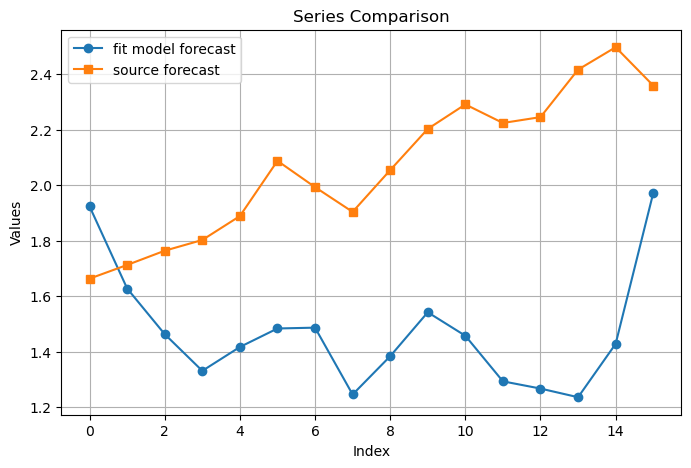

In [38]:
# 创建图表
plt.figure(figsize=(8, 5))  # 设置图像大小
plt.plot(rmse_series, label="fit model forecast", marker='o')  # 绘制第一条线
plt.plot(source_model_series_split, label="source forecast", marker='s')  # 绘制第二条线

# 添加标题和标签
plt.title("Series Comparison")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()  # 显示图例
plt.grid()  # 添加网格线

# 显示图表
plt.show()